# Import Packages

In [54]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import shap
from matplotlib import pyplot as plt

In [2]:
LABEL_COL = 'Reservation_Status'

In [3]:
TRAIN_SET = '../data/Hotel-A-train.csv'
VAL_SET = '../data/Hotel-A-validation.csv'
TEST_SET = '../data/Hotel-A-test.csv'

In [111]:
df = pd.read_csv(TRAIN_SET, index_col='Reservation-id', 
                 parse_dates=['Expected_checkin', 'Expected_checkout', 'Booking_date'])
df_val = pd.read_csv(VAL_SET, index_col='Reservation-id', 
                     parse_dates=['Expected_checkin', 'Expected_checkout', 'Booking_date'])
df_test = pd.read_csv(TEST_SET, index_col='Reservation-id', 
                      parse_dates=['Expected_checkin', 'Expected_checkout', 'Booking_date'])

# Data Preprocessing

In [113]:
df[LABEL_COL] = df[LABEL_COL].map({'Check-In':1, 'Canceled':2, 'No-Show':3}).astype(int)
df_val[LABEL_COL] = df_val[LABEL_COL].map({'Check-In':1, 'Canceled':2, 'No-Show':3}).astype(int)

## Feature Engineering

In [130]:
df['stay_length'] = (df.Expected_checkout - df.Expected_checkin).dt.days
df_val['stay_length'] = (df_val.Expected_checkout - df_val.Expected_checkin).dt.days
df_test['stay_length'] = (df_test.Expected_checkout - df_test.Expected_checkin).dt.days

In [131]:
df['income_amount'] = df.Income.map({'<25K':25, '50K -- 100K':100, '25K --50K':50, '>100K':200})
df_val['income_amount'] = df_val.Income.map({'<25K':25, '50K -- 100K':100, '25K --50K':50, '>100K':200})
df_test['income_amount'] = df_test.Income.map({'<25K':25, '50K -- 100K':100, '25K --50K':50, '>100K':200})

In [132]:
df['num_rooms'] = np.ceil((df.Adults + df.Children)/5).astype(int)
df_val['num_rooms'] = np.ceil((df_val.Adults + df_val.Children)/5).astype(int)
df_test['num_rooms'] = np.ceil((df_test.Adults + df_test.Children)/5).astype(int)

In [133]:
df['total_cost'] = df.num_rooms*df.Room_Rate*df.stay_length
df_val['total_cost'] = df_val.num_rooms*df_val.Room_Rate*df_val.stay_length
df_test['total_cost'] = df_test.num_rooms*df_test.Room_Rate*(1 - df_test.Discount_Rate/100)*df_test.stay_length

In [134]:
df.shape

(27499, 27)

In [135]:
df.Reservation_Status.value_counts()

1    21240
2     4134
3     2125
Name: Reservation_Status, dtype: int64

In [136]:
df.Deposit_type.value_counts()/df.shape[0]

No Deposit        0.663442
Refundable        0.253973
Non-Refundable    0.082585
Name: Deposit_type, dtype: float64

In [137]:
df.groupby('Deposit_type').total_cost.mean()

Deposit_type
No Deposit        372.157586
Non-Refundable    372.691325
Refundable        371.586197
Name: total_cost, dtype: float64

In [138]:
df['income_ratio'] = df.income_amount/df.total_cost
df_val['income_ratio'] = df_val.income_amount/df_val.total_cost
df_test['income_ratio'] = df_test.income_amount/df_test.total_cost

In [139]:
df['adults_to_child'] = df.Children/df.Adults
df['adults_to_babies'] = df.Children/df.Adults
df['total_people'] = df.Adults + df.Children + df.Babies

df_val['adults_to_child'] = df_val.Children/df_val.Adults
df_val['adults_to_babies'] = df_val.Children/df_val.Adults
df_val['total_people'] = df_val.Adults + df_val.Children + df_val.Babies

df_test['adults_to_child'] = df_test.Children/df_test.Adults
df_test['adults_to_babies'] = df_test.Babies/df_test.Adults
df_test['total_people'] = df_test.Adults + df_test.Children + df_test.Babies

In [140]:
df['checkin_day'] = df.Expected_checkin.dt.day
df['checkin_week'] = df.Expected_checkin.dt.week
df['checkin_dayofweek'] = df.Expected_checkin.dt.dayofweek
df['checkin_month'] = df.Expected_checkin.dt.month
df['checkin_year'] = df.Expected_checkin.dt.year

df_val['checkin_day'] = df_val.Expected_checkin.dt.day
df_val['checkin_week'] = df_val.Expected_checkin.dt.week
df_val['checkin_dayofweek'] = df_val.Expected_checkin.dt.dayofweek
df_val['checkin_month'] = df_val.Expected_checkin.dt.month
df_val['checkin_year'] = df_val.Expected_checkin.dt.year

df_test['checkin_day'] = df_test.Expected_checkin.dt.day
df_test['checkin_week'] = df_test.Expected_checkin.dt.week
df_test['checkin_dayofweek'] = df_test.Expected_checkin.dt.dayofweek
df_test['checkin_month'] = df_test.Expected_checkin.dt.month
df_test['checkin_year'] = df_test.Expected_checkin.dt.year

In [141]:
df['days_to_booking'] = (df.Expected_checkin - df.Booking_date).dt.days.clip(lower=0)
df_val['days_to_booking'] = (df_val.Expected_checkin - df_val.Booking_date).dt.days.clip(lower=0)
df_test['days_to_booking'] = (df_test.Expected_checkin - df_test.Booking_date).dt.days.clip(lower=0)

In [142]:
df['days_to_stay_ratio'] = df.days_to_booking / df.stay_length 
df_val['days_to_stay_ratio'] = df_val.days_to_booking / df_val.stay_length 
df_test['days_to_stay_ratio'] = df_test.days_to_booking / df_test.stay_length 

## Drop columns

In [89]:
drop_cols = ['Expected_checkin', 'Expected_checkout', 'Booking_date', 'Ethnicity', 'Educational_Level']

In [90]:
df = df.drop(columns=drop_cols)
df_val = df_val.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

## Dummy label for submission test set

In [91]:
df_test[LABEL_COL] = 'abc'

## Categorical encoding

In [92]:
categorical_features_indices = np.where((df.dtypes != np.float) & (df.dtypes != np.int64)  & (df.dtypes != np.int32))[0]

In [93]:
cat_cols = list(set(df.columns[categorical_features_indices].to_list()) - set([LABEL_COL]) - set(drop_cols))

## Target Encoding

In [94]:
# le_target = OneHotEncoder(cols=[LABEL_COL], use_cat_names=True)
# le_target.fit(df[[LABEL_COL]].astype(str))
# df_l = le_target.transform(df[[LABEL_COL]].astype(str))
# class_names = df_l.columns

# df_cat = df[cat_cols]
# df = df.drop(columns=cat_cols)
# t_enc_dict = {}
# for cl in class_names:
#     enc = TargetEncoder()
#     enc.fit(df_cat, df_l[cl])
#     t_enc_dict[cl] = enc
#     temp = t_enc_dict[cl].transform(df_cat)
#     temp.columns = [str(x)+'_'+str(cl) for x in temp.columns]
#     df = pd.concat([df, temp], axis=1)

In [95]:
# df_cat = df_val[cat_cols]
# df_val = df_val.drop(columns=cat_cols)
# for cl in class_names:
#     temp = t_enc_dict[cl].transform(df_cat)
#     temp.columns = [str(x)+'_'+str(cl) for x in temp.columns]
#     df_val = pd.concat([df_val, temp], axis=1)

In [96]:
# df_cat = df_test[cat_cols]
# df_test = df_test.drop(columns=cat_cols)
# for cl in class_names:
#     temp = t_enc_dict[cl].transform(df_cat)
#     temp.columns = [str(x)+'_'+str(cl) for x in temp.columns]
#     df_test = pd.concat([df_test, temp], axis=1)

## One Hot Encoding

In [97]:
# onehot_enc = OrdinalEncoder(cols=cat_cols, use_cat_names=True)
# onehot_enc.fit(df)

# df = onehot_enc.transform(df)
# df_val = onehot_enc.transform(df_val)
# df_test = onehot_enc.transform(df_test)

## Label Encoding

In [98]:
l_enc = OrdinalEncoder(cols=cat_cols)
l_enc.fit(df)

df = l_enc.transform(df)
df_val = l_enc.transform(df_val)
df_test = l_enc.transform(df_test)

### Convert to categorical type for LGBM

In [99]:
# df[cat_cols] = df[cat_cols].astype('category')
# df_val[cat_cols] = df_val[cat_cols].astype('category')
# df_test[cat_cols] = df_test[cat_cols].astype('category')

## Drop encoded categorical based on feature importance

In [100]:
# drop_cat = ['Country_region_West', 'Country_region_East', 'Deposit_type_Non-Refundable','Deposit_type_Refundable', "Children", "Income_<25K"]

In [101]:
# df = df.drop(columns=drop_cat)
# df_val = df_val.drop(columns=drop_cat)
# df_test = df_test.drop(columns=drop_cat)

# Write Datasets to CSV


In [102]:
df.to_csv('../data/preprocessed_train_only_Mar13_0940pm_onehot_enc_with_dates.csv')
df_val.to_csv('../data/preprocessed_val_only_Mar13_0940pm_onehot_enc_with_dates.csv')

In [103]:
df_test.to_csv('../data/preprocessed_test_only_Mar13_0940pm_onehot_enc_with_dates.csv')

# Create Train/Test Dataset

In [40]:
X = df.drop(columns='Reservation_Status')
y = df['Reservation_Status']

In [41]:
val_X = df_val.drop(columns='Reservation_Status')
val_y = df_val['Reservation_Status']

In [42]:
sub_X = df_test.drop(columns='Reservation_Status')

In [43]:
train_X = X
train_y = y

## Oversample using SMOTE

In [44]:
# oversample = SMOTE()
# train_X, train_y = oversample.fit_resample(train_X, train_y)

# Model Training

In [45]:
model = LGBMClassifier(class_weight='balanced', n_estimators=900, learning_rate=0.01, max_depth=8, min_child_samples=400, num_leaves=24)

In [46]:
model.fit(train_X, train_y, verbose=0)

LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=8,
               min_child_samples=400, n_estimators=900, num_leaves=24)

# Model Evaluation

In [47]:
pred_y_train = model.predict(train_X)
pred_y_val = model.predict(val_X)

In [48]:
print(f1_score(train_y, pred_y_train, average='macro'))

0.5041117478483343


In [49]:
print(f1_score(val_y, pred_y_val, average='macro'))

0.33225051921055543


# Model Interpretation

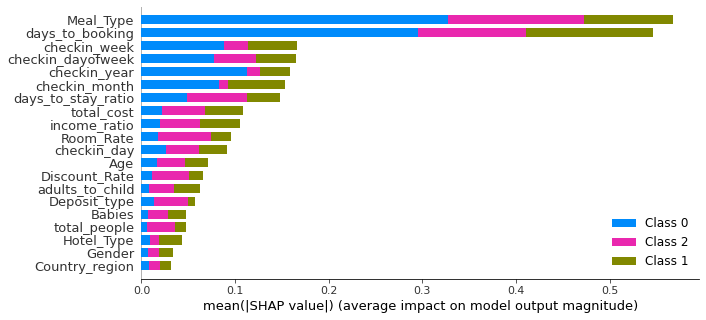

In [75]:
plt.figure(figsize=(5,20))
shap.summary_plot(shap_values, val_X, plot_type="bar", plot_size=(10,5))
plt.show()

In [107]:
pd.to_datetime('today').dayofweek

6

In [105]:
df.checkin_dayofweek.value_counts()

0    4460
3    4109
1    4087
4    4062
2    3959
6    3798
5    3024
Name: checkin_dayofweek, dtype: int64

IndexError: index 21388 is out of bounds for axis 0 with size 2749

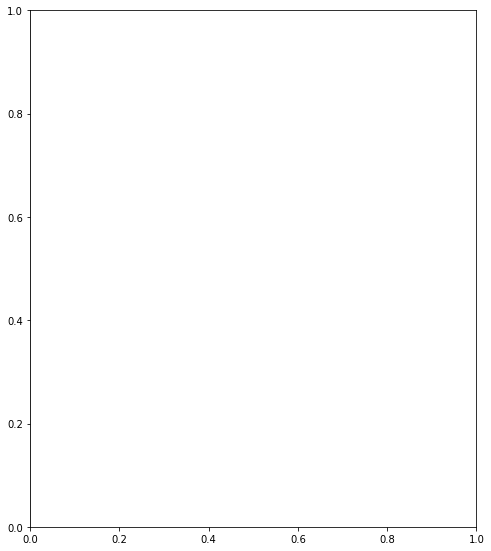

In [76]:
shap.summary_plot(shap_values[0], val_X)

In [ ]:
df.che

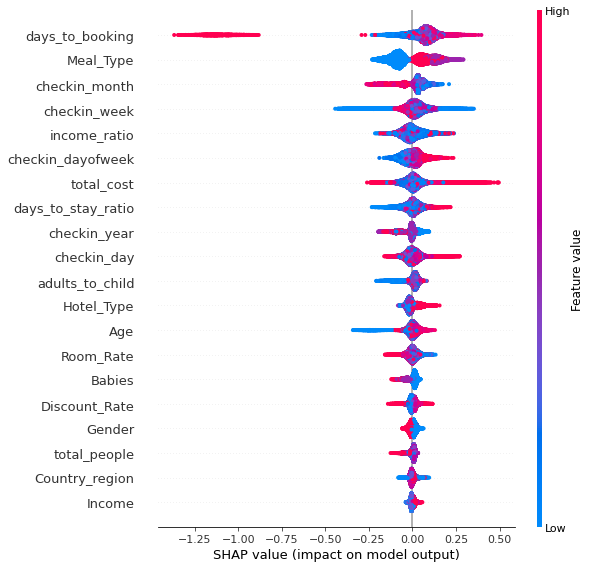

In [69]:
shap.summary_plot(shap_values[1], train_X)

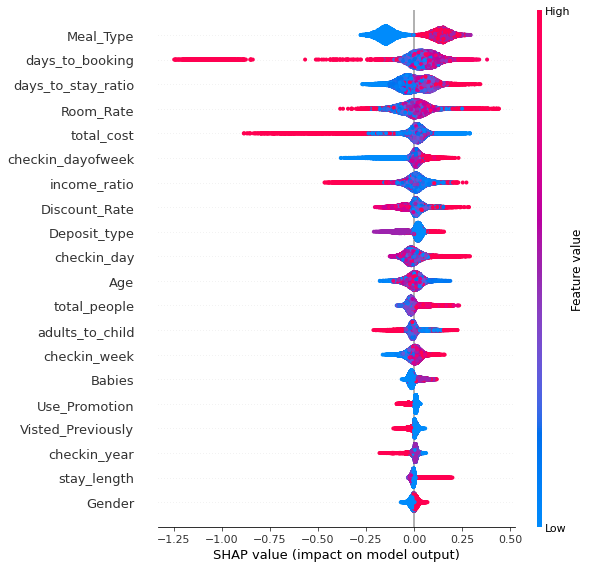

In [70]:
shap.summary_plot(shap_values[2], train_X)

In [50]:
feat_i = pd.Series(model.feature_importances_, index=train_X.columns).sort_values(ascending=False)

In [71]:
print(feat_i)

days_to_booking           7248
checkin_week              5341
days_to_stay_ratio        4775
total_cost                4700
income_ratio              4542
Room_Rate                 4389
checkin_day               3623
Age                       3468
checkin_dayofweek         2629
checkin_year              2088
Meal_Type                 1550
Discount_Rate             1500
checkin_month             1498
adults_to_child           1473
Hotel_Type                 960
total_people               896
Country_region             804
Gender                     734
Booking_channel            724
Deposit_type               708
Income                     683
Babies                     541
Children                   477
Adults                     474
Visted_Previously          403
stay_length                382
income_amount              250
Use_Promotion              233
Required_Car_Parking       223
Previous_Cancellations     182
num_rooms                   33
adults_to_babies             0
dtype: i

# submission CSV

In [80]:
sub_y = model.predict(sub_X)

df_test['pred_y'] = sub_y
sub_s = df_test.pred_y
sub_s.name = 'Reservation_status'
sub_s.to_frame().to_csv('../output/submission_file_13Mar_02_00_am.csv', header=True)